##### PROJETO INTEGRADOR  |  PREVISÃO DE DEMANDA  |   VENDAS AUTOPEÇAS (GRUPO 100 VIES)


# TIME SERIES: PRODUTO A PRODUTO

# IMPORTANDO BILIOTECAS E CSV

In [8]:
#IMPORTANDO BIBLIOTECAS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly
import os
import janitor


from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
#from imblearn.over_sampling import SMOTE

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

import plotly_express as px

In [9]:
vendastelepweek=pd.read_csv("4-VendasTelepWeek-Rev3.csv",sep=',',encoding='Latin1')
vendastelepweek.head()

,Codigo,0,1,2,3,4,5,6,7,8,...,99,100,101,102,103,104,105,106,107,108
0,1,0,0,0,0,0,2,2,4,2,...,9,10,8,8,10,0,6,10,6,2
1,2,0,0,0,0,0,0,0,4,2,...,5,8,2,6,10,0,4,6,4,8
2,3,0,0,0,0,0,0,0,0,0,...,5,0,0,4,4,0,0,10,6,2
3,4,0,0,0,0,0,0,0,0,0,...,2,0,0,0,4,0,0,4,6,0
4,5,0,0,0,0,0,0,5,0,2,...,13,25,30,6,0,0,0,17,10,0


In [10]:
melt = vendastelepweek.melt(id_vars='Codigo', var_name='Week',value_name='Vendas')
melt = melt.sort_values(['Week','Codigo']).reset_index(drop=True)
melt['Week'] = melt['Week'].astype(int)
melt = melt.sort_values(['Week','Codigo']).reset_index(drop=True)
melt.tail()

,Codigo,Week,Vendas
20814,197,108,0
20815,198,108,0
20816,199,108,0
20817,200,108,0
20818,201,108,0


# TIME SERIES: MODELO MA (MOVING AVERAGE)
## Para efeito de visualização global, foram somadas as vendas de todos os produtos agrupadas por semana. No próximo tópico (12.2) será analisada a time-series individualizada por Código de Produto, atendendo mais assertivamente à necessidade de negócio que é a previsão de demanda do estoque.

In [11]:
# Function to plot moving average together with original data

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    # Calculate and plot rolling mean
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    
    # Plot original series values
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [12]:
ma = melt.copy()
ma = ma.drop(['Codigo'],axis=1)
ma = ma.set_index('Week', drop = True)
ma = ma.groupby(['Week'])['Vendas'].sum()
ma.tail()

Week
104     18
105     49
106    344
107    239
108    132
Name: Vendas, dtype: int64

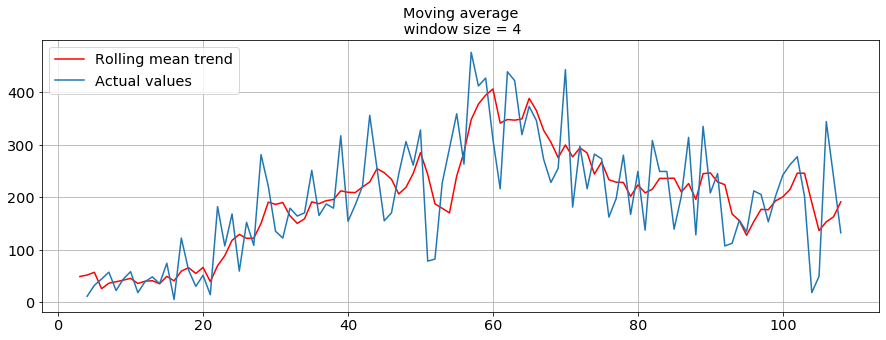

In [13]:
# Vendas moving average plot for 4 weeks
plotMovingAverage(ma, 4) 

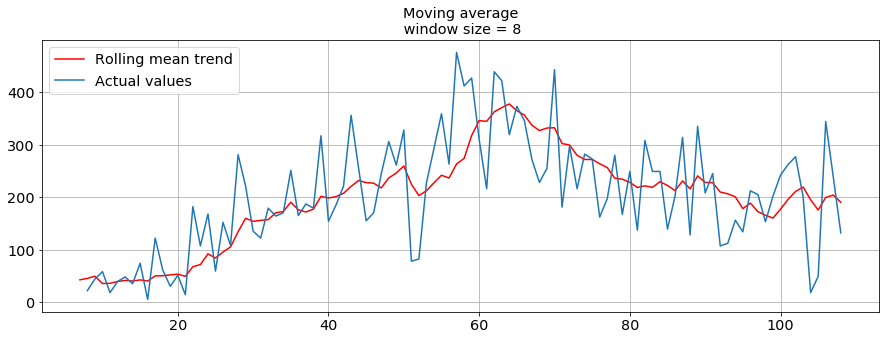

In [14]:
# Vendas moving average plot for 8 weeks
plotMovingAverage(ma, 8) 

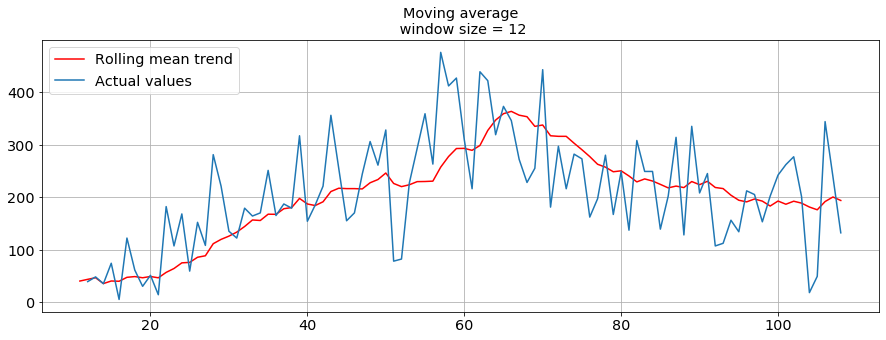

In [15]:
# Vendas moving average plot for 4 weeks
plotMovingAverage(ma, 12) 

## Time Series e M.A. de cada produto individualmente. 
Para efeito de visualização e testes com os modelos serão considerados os Top 2 produtos com maior frequência de Vendas. Quando definido o melhor modelo, será iterado para os Top 100 para validação da performance.

In [16]:
for c in range (1,3):
    cod = melt2[melt2['Codigo'] == c]
    x=(cod.groupby(['Week']))['Week'].nunique().index
    y=pd.DataFrame(cod.groupby(['Week'])['Vendas'].sum())
    TotVendas = (cod.Vendas>0).sum()
    TotUnid = melt2.Vendas[melt2['Codigo'] == c].sum()
    title=print(f'Produto {c}\nTotal de Vendas: {TotVendas}\nTotal de Unid. Vendidas: {TotUnid}')
    fig = px.line(cod, x="Week", y="Vendas",title=title,width=800, height=200)
    fig.show()

NameError: name 'melt2' is not defined

# ACF  |  PACF  |  Dickey-Fuller test
ACF (Auto Correlation Function) | PACF (Partial ACF) | Dickey-Fuller para verificar se um modelo autorregressivo tem ou não raiz unitária

In [20]:
# Function to plot ACF and PACF Dickey-Fuller test

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

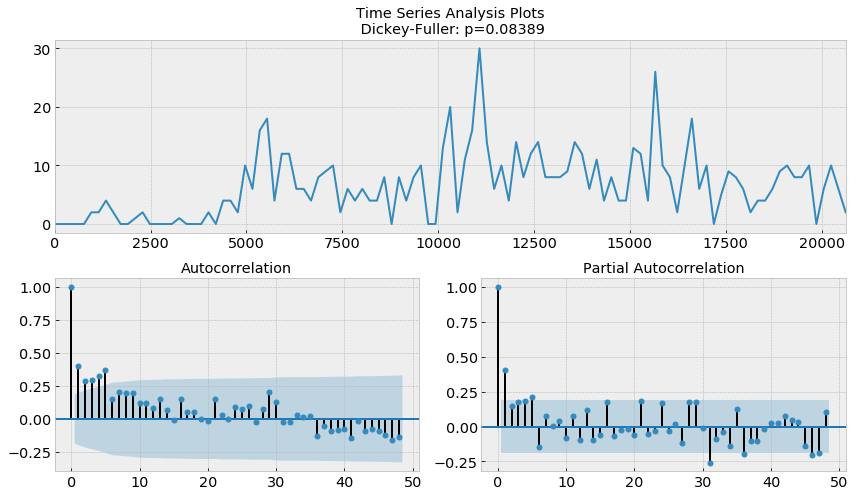

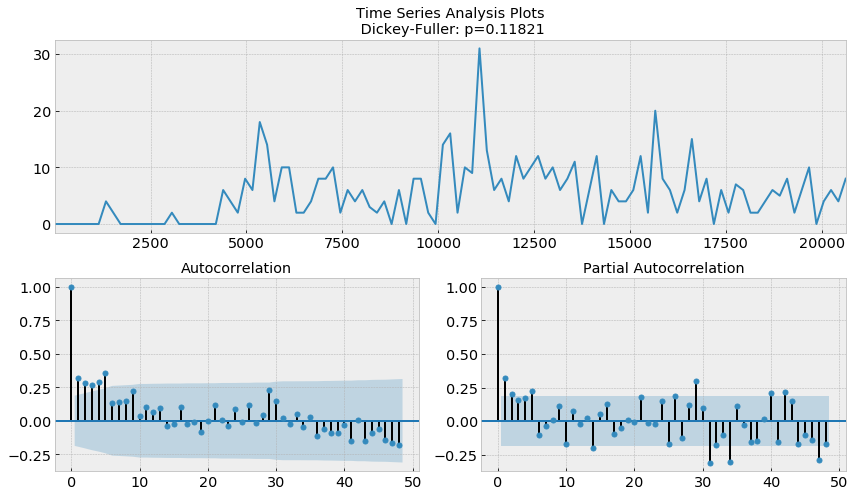

In [21]:
# plot for ads with 48 lags
for c in range (1,3):
    cod = melt[melt['Codigo'] == c]
    tsplot(cod.Vendas, lags=48)

As séries iniciais são estacionárias; o teste de Dickey-Fuller rejeitou a hipótese nula de que uma raiz unitária está presente. Na verdade, podemos ver isso no próprio gráfico - não temos uma tendência visível; portanto, a média é constante e a variação é praticamente estável. A única coisa que resta é a sazonalidade, com a qual temos que lidar antes da modelagem. Para fazer isso, vamos usar a "diferença sazonal", que significa uma simples subtração da série de si mesma com um atraso igual ao período sazonal.

# DIFERENÇA SAZONAL: 
Subtração da série de si mesma com um atraso igual ao período sazonal

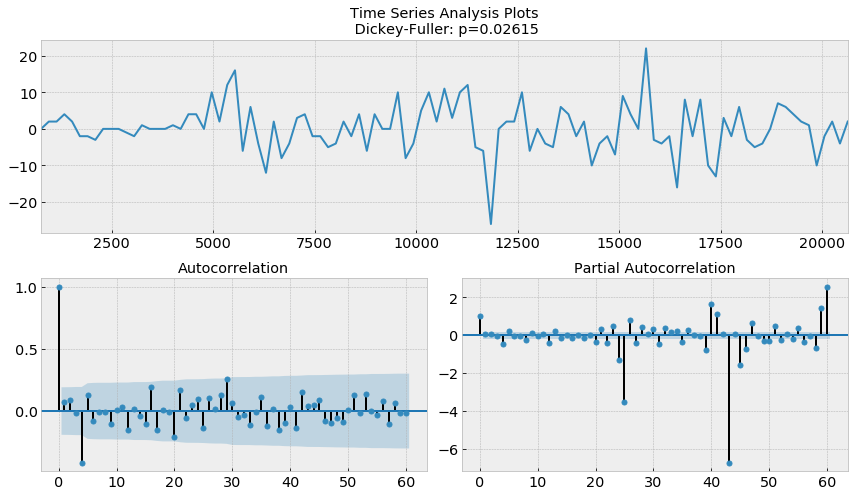

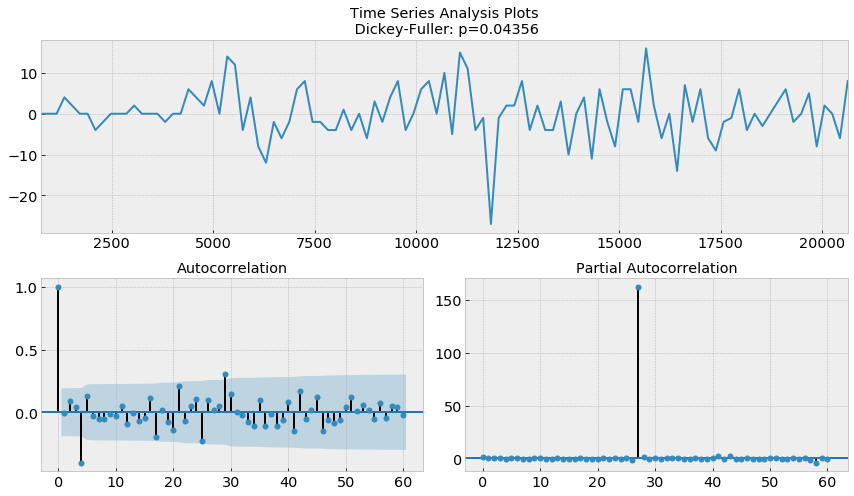

In [22]:
# Plot of ads stationary series by SARIMA
for c in range (1,3):
    cod = melt[melt['Codigo'] == c]
    cod_diff = cod.Vendas - cod.Vendas.shift(4)
    tsplot(cod_diff[4:], lags=60)

# TESTANDO DIFERENTES MODELOS

In [23]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 4 # season length 4 weeks

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [24]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(cod_Vendas, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [25]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements